In [38]:
import pandas as pd
import seaborn as sns
import statsmodels as sm

In [39]:
train_dat = pd.read_csv("recruiting_zeta-disease_training-data_take-home-challenge - 2021_zeta-disease_training-data_take-home-challenge.csv")
x_train = train_dat.iloc[:,0:8]
y_train = train_dat["zeta_disease"]

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'weight'),
 Text(2.5, 0, 'bmi'),
 Text(3.5, 0, 'blood_pressure'),
 Text(4.5, 0, 'insulin_test'),
 Text(5.5, 0, 'liver_stress_test'),
 Text(6.5, 0, 'cardio_stress_test'),
 Text(7.5, 0, 'years_smoking'),
 Text(8.5, 0, 'zeta_disease')]

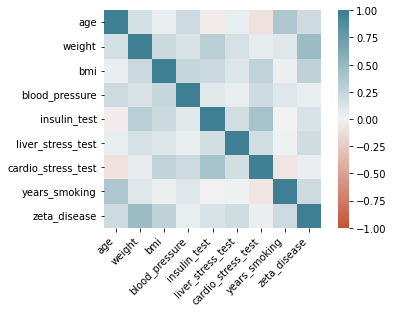

In [40]:
corr = train_dat.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

The initial exploration of the data suggests some moderate correlations with a number of variables, especially weight and bmi. Nothing stands out as particularly troublesome as far as covaraince between predictors. The covariance between predictors is low enough that it is very unlikely that interaction terms are going to be useful. A simple logit model may be a pretty good fit given the low number of variables. It also has the advantage of retaining scrutability.

Below I'm going to:
 - Begin with the full model with all variables. I'm using statsmodel instead of sklearn because it gives me easy access to summaries of my model. One note here is that statsmod does true logistic regression, where sklearn uses l2 peanalizatoin by default. So the results may be slightly different.
 - I'll evaluate variables with their z-values and associated p-values and decide which to drop.
 - I will use BIC (Bayesian informatoin criterion) as my main measure of model fit, as it penalizes complex models and keeps over-fitting under control.
 - I could "automate" this process with a function for backward selection, but given the small number of variables, I like to be able to go through them manually and decide if what is happening makes substantive sense. 
 - Prefer backwards selection over forward selection because you quickly see if things aren't working (because p-values and coefficients will change wildely when you drop a variable)

In [41]:
full_mod = sm.api.Logit(y_train,x_train).fit()
print(full_mod.summary())
print("BIC:",full_mod.bic)


Optimization terminated successfully.
         Current function value: 0.622737
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  800
Model:                          Logit   Df Residuals:                      792
Method:                           MLE   Df Model:                            7
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.03701
Time:                        20:49:54   Log-Likelihood:                -498.19
converged:                       True   LL-Null:                       -517.34
Covariance Type:            nonrobust   LLR p-value:                 2.667e-06
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                    0.0014      0.006      0.230      0.818      -0.011       0.014
weigh

Clearly age is not a good predictory. Additionaly, BMI is a poor predictor, and may be stealing significance from weight (with BMI being linear dependant on weight and height). Removing these two variables should mix things up.

In [42]:
x_train = x_train.drop(["bmi","age"],axis=1)

reduced_mod_1 = sm.api.Logit(y_train,x_train).fit()
print(reduced_mod_1.summary())
print("BIC:",reduced_mod_1.bic)


Optimization terminated successfully.
         Current function value: 0.623270
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  800
Model:                          Logit   Df Residuals:                      794
Method:                           MLE   Df Model:                            5
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.03618
Time:                        20:49:54   Log-Likelihood:                -498.62
converged:                       True   LL-Null:                       -517.34
Covariance Type:            nonrobust   LLR p-value:                 4.892e-07
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
weight                 0.0045      0.002      2.694      0.007       0.001       0.008
blood

This model does improve the aic, suggesting it is a more parsimonious model. We now see years smoking, weigh, and blood preassure as clear standouts. cardio and liver stress tests are non-significant, however, liver_stress_test is only marginally insignificant at the (arbitrary) .05 cutoff, so we will only drop cardio stress test this round and see what happens. 

In [43]:
x_train = x_train.drop(["cardio_stress_test"],axis=1)

reduced_mod_2 = sm.api.Logit(y_train,x_train).fit()
print(reduced_mod_2.summary())
print("BIC:",reduced_mod_2.bic)

Optimization terminated successfully.
         Current function value: 0.624835
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  800
Model:                          Logit   Df Residuals:                      795
Method:                           MLE   Df Model:                            4
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.03376
Time:                        20:49:55   Log-Likelihood:                -499.87
converged:                       True   LL-Null:                       -517.34
Covariance Type:            nonrobust   LLR p-value:                 4.792e-07
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
weight                0.0044      0.002      2.644      0.008       0.001       0.008
blood_pr

This model actually does marginally worse as measured by BIC. However, it now becomes clear that our stress tests are measures of our "true" causal variables:

- Liver measures smoking
- Insulin measures weight
- Cardio measures some combindation of weight/blood preassure/ and smoking

So, we drop these distractors and focus in on the simpler model of direct measures of health.

In [44]:
x_train = x_train.drop(["liver_stress_test","insulin_test"],axis=1)

final_mod = sm.api.Logit(y_train,x_train).fit()
print(final_mod.summary())
print("BIC:",final_mod.bic)

Optimization terminated successfully.
         Current function value: 0.629132
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           zeta_disease   No. Observations:                  800
Model:                          Logit   Df Residuals:                      797
Method:                           MLE   Df Model:                            2
Date:                Thu, 14 Apr 2022   Pseudo R-squ.:                 0.02712
Time:                        20:49:55   Log-Likelihood:                -503.31
converged:                       True   LL-Null:                       -517.34
Covariance Type:            nonrobust   LLR p-value:                 8.072e-07
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
weight             0.0061      0.002      3.962      0.000       0.003       0.009
blood_pressure   

Our BIC is substantially improved here, and this model intuitvely makes sense as it uses the underlying medical conditions, not noisy measurements of those conditions. The code below outputs predictions for the 20 test data points. I'm leaving them in probability format. We could turn these into "hard predictions" based on a cutoff. However, the cutoff to choose is dependant on disease prevalance in the population, allocation of treatement resources etc. An ROC curve would give us some practical emperical informatoin about what a good cutoff may be, but more information from shareholders would be needed to make this decision. 

In [45]:
test_dat = pd.read_csv("recruiting_zeta-disease_prediction-data_take-home-challenge - 2021-01-21_zeta-disease_prediction-data_take-home-challenge.csv")
x_test = test_dat[["weight","blood_pressure","years_smoking"]]
print("Predictions for our twenty points:")
final_mod.predict(x_test)

Predictions for our twenty points:


0     0.351487
1     0.305167
2     0.274420
3     0.441616
4     0.550564
5     0.225274
6     0.366273
7     0.377731
8     0.517437
9     0.303628
10    0.495156
11    0.403752
12    0.250105
13    0.390251
14    0.270581
15    0.583505
16    0.242845
17    0.572558
18    0.398273
19    0.183926
dtype: float64